In [1]:
import torch
import torch.nn as nn  
import torch.optim as optim

In [2]:
import urllib.request
import zipfile
import os
 
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
ZIP_PATH = "UCI_HAR_Dataset.zip"
EXTRACT_DIR = "data"
 
if not os.path.exists(ZIP_PATH):
    print("Downloading UCI HAR dataset...")
    urllib.request.urlretrieve(URL, ZIP_PATH)
 
 
if not os.path.exists(os.path.join(EXTRACT_DIR, "UCI HAR Dataset")):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
 
print("Done.")

Done.


In [3]:
import numpy as np
import os
 
BASE = "data/UCI HAR Dataset"
 
def load_har(split="train"):
    base = os.path.join(BASE, split, "Inertial Signals")
    signals = [
        "body_acc_x", "body_acc_y", "body_acc_z",
        "body_gyro_x", "body_gyro_y", "body_gyro_z",
        "total_acc_x", "total_acc_y", "total_acc_z",
    ]
 
    X = []
    for s in signals:
        X.append(
            np.loadtxt(os.path.join(base, f"{s}_{split}.txt"))
        )
 
    X = np.stack(X, axis=-1)              # (N, 128, 9)
    y = np.loadtxt(
        os.path.join(BASE, split, f"y_{split}.txt")
    ) - 1                                 # Labels 0..5
 
    return X.astype("float32"), y.astype("int32")

In [4]:
X_train, y_train = load_har("train")
X_test,  y_test  = load_har("test")

 

print(X_train.shape)  # (7352, 128, 9)
print(y_train.shape)  # (7352,)

 

mean = X_train.mean(axis=(0, 1), keepdims=True)
std  = X_train.std(axis=(0, 1), keepdims=True) + 1e-6

 

X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std




(7352, 128, 9)
(7352,)


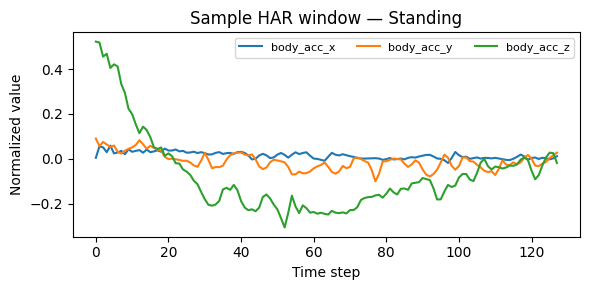

In [5]:
import matplotlib.pyplot as plt
 
class_names = [
    'Walking',
    'Walking Upstairs',
    'Walking Downstairs',
    'Sitting',
    'Standing',
    'Laying',
]
 
idx = 0  # change to view a different sample
t = range(X_train.shape[1])
activity = class_names[int(y_train[idx])]
 
plt.figure(figsize=(6, 3))
plt.plot(t, X_train[idx, :, 0], label='body_acc_x')
plt.plot(t, X_train[idx, :, 1], label='body_acc_y')
plt.plot(t, X_train[idx, :, 2], label='body_acc_z')
plt.xlabel('Time step')
plt.ylabel('Normalized value')
plt.title(f'Sample HAR window — {activity}')
plt.legend(fontsize=8, ncol=3)
plt.tight_layout()
plt.show()

 

In [6]:
from torch.utils.data import TensorDataset, DataLoader

BATCH = 64
device = "mps" #or mps or cuda

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long()) #ds stands for data set
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False) #(BATCH, 128, 9)


In [ ]:
class hRNN(nn.Module):
    def __init__(self, num_classes=6, input_size=9, hidden_size= 32, drop_rate = 0.5, fc_size=120): #9sensors, 6classes, size vector of h_t is 32
        super().__init__()

        #this is automated feature extraction
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True) #if batch_first = False ->(128, BATCH, 9)
                                                                        #if batch_first = True -> (BATCH, 128, 9)
        
        #this is classifier
        self.fc1 = nn.Linear(hidden_size, fc_size)
        self.bnn = nn.BatchNorm1d(fc_size)
        self.drop = nn.Dropout(drop_rate)
        self.fc2 = nn.Linear(fc_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:,-1,:]#flatten
        out = torch.relu(self.fc1(out))
        out = self.bnn(out)
        out = self.drop(out)
        return self.fc2(out)
    
model = hRNN(input_size=9, hidden_size=128, num_classes=6).to(device)

In [8]:
def train_rnn(patience = 5, lr = 1e-3):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= lr) #Adam  is modern gradient method

    epochs=30
    #patience=5 #Patience is the number of consecutive epochs
    best_val_loss = float('inf')
    patince_left = patience
    best_state = None

    history={"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = .0
        train_correct = 0
        train_count = 0

        for xb, yb in train_loader:
            xb= xb.to(device)
            yb=yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss_out = loss(logits, yb)
            loss_out.backward()
            optimizer.step()

            batch_size = yb.size(0)
            train_loss += loss_out.item() * batch_size
            train_correct += (logits.argmax(dim=1) == yb).sum().item() # number of correctly classified samples
            train_count += batch_size

        train_loss /= train_count
        train_acc = train_correct / train_count

        model.eval() #Test data
        val_loss = 0
        val_correct = 0
        val_count = 0

        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                logits = model(xb)
                loss_out = loss(logits, yb)

                batch_size = yb.size(0)
                val_loss += loss_out.item() * batch_size
                val_correct += (logits.argmax(dim=1) == yb).sum().item() #number of correctly classified
                val_count += batch_size
        
        val_loss /= val_count
        val_acc = val_correct / val_count

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        
        print(
            f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} acc={val_acc:.4f}"
        )

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_val_accuracy = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()} #save the weights
            patience_left = patience
        
        else:
            patience_left -=1
            if patience_left == 0:
                print("Early stopping")
                break
            if best_state is not None:
                model.load_state_dict(best_state)
            return best_val_accuracy

# Hyperparameter optimization


In [9]:
patients_list = [3,5,7]
lr_list = [1e-2, 1e-3, 1e-5]
hidden_list = [16, 32, 64, 128, 256]
dropout_list = [0.2, 0.3, 0.4, 0.5]
fc_list = [64, 128, 256]

results = {}
for h in hidden_list:
    for fc in fc_list:
        model = hRNN(input_size=9, hidden_size=h, fc_size= fc).to(device)
        results[(h, fc)] = train_rnn()

Epoch 01 | train_loss=1.2037 acc=0.5543 | val_loss=0.9327 acc=0.6091
Epoch 02 | train_loss=0.8252 acc=0.6669 | val_loss=0.8037 acc=0.6685
Epoch 03 | train_loss=0.7222 acc=0.7010 | val_loss=0.7646 acc=0.6773
Epoch 04 | train_loss=0.6709 acc=0.7150 | val_loss=0.7216 acc=0.6817
Epoch 05 | train_loss=0.6368 acc=0.7303 | val_loss=0.7005 acc=0.6970
Epoch 06 | train_loss=0.6149 acc=0.7413 | val_loss=0.6903 acc=0.6949
Epoch 07 | train_loss=0.5819 acc=0.7503 | val_loss=0.6798 acc=0.7007
Epoch 08 | train_loss=0.5669 acc=0.7580 | val_loss=0.6708 acc=0.7184
Epoch 09 | train_loss=0.5468 acc=0.7701 | val_loss=0.6750 acc=0.7204
Epoch 01 | train_loss=1.0692 acc=0.5970 | val_loss=0.8766 acc=0.6597
Epoch 02 | train_loss=0.7273 acc=0.6952 | val_loss=0.7901 acc=0.6949
Epoch 03 | train_loss=0.6389 acc=0.7308 | val_loss=0.7637 acc=0.6977
Epoch 04 | train_loss=0.6070 acc=0.7471 | val_loss=0.7673 acc=0.7095
Epoch 01 | train_loss=0.9582 acc=0.6202 | val_loss=0.7761 acc=0.6766
Epoch 02 | train_loss=0.6600 acc=0

In [11]:
# Random Search
import random
patience_list = [3,5,7]
lr_list = [1e-2, 1e-3, 1e-5]
hidden_list = [16, 32, 64, 128, 256]
dropout_list = [0.2, 0.3, 0.4, 0.5]
fc_list = [64, 128, 256]

n_trials = 7

results_random ={}

for _ in range(n_trials):
    patience = random.choice(patience_list)
    lr = random.choice(lr_list)
    h = random.choice(hidden_list)
    drop = random.choice(dropout_list)
    fc = random.choice(fc_list)
    model = hRNN(hidden_size=h, drop_rate=drop, fc_size=fc).to(device)
    results_random[(patience, lr, h, drop, fc)] = train_rnn(patience=patience, lr=lr)

    

    

Epoch 01 | train_loss=0.8735 acc=0.6527 | val_loss=4.2156 acc=0.3332
Epoch 02 | train_loss=1.4407 acc=0.4538 | val_loss=1.2009 acc=0.5039
Epoch 03 | train_loss=1.4206 acc=0.4588 | val_loss=1.3738 acc=0.3675
Epoch 01 | train_loss=1.8421 acc=0.2231 | val_loss=1.7388 acc=0.2810
Epoch 02 | train_loss=1.7312 acc=0.3035 | val_loss=1.6510 acc=0.3699
Epoch 03 | train_loss=1.6388 acc=0.3736 | val_loss=1.5694 acc=0.4496
Epoch 04 | train_loss=1.5568 acc=0.4411 | val_loss=1.4954 acc=0.4723
Epoch 05 | train_loss=1.4841 acc=0.4714 | val_loss=1.4172 acc=0.4975
Epoch 06 | train_loss=1.4198 acc=0.5064 | val_loss=1.3707 acc=0.5073
Epoch 07 | train_loss=1.3633 acc=0.5243 | val_loss=1.3236 acc=0.5212
Epoch 08 | train_loss=1.3061 acc=0.5450 | val_loss=1.2800 acc=0.5304
Epoch 09 | train_loss=1.2649 acc=0.5590 | val_loss=1.2387 acc=0.5358
Epoch 10 | train_loss=1.2342 acc=0.5600 | val_loss=1.2067 acc=0.5372
Epoch 11 | train_loss=1.1950 acc=0.5720 | val_loss=1.1854 acc=0.5433
Epoch 12 | train_loss=1.1572 acc=0

In [12]:
results_random

{(7, 0.01, 64, 0.4, 256): 0.503902273498473,
 (3, 1e-05, 16, 0.3, 256): 0.6155412283678316,
 (7, 1e-05, 64, 0.4, 64): None,
 (5, 1e-05, 64, 0.3, 256): 0.7017305734645403,
 (7, 0.001, 64, 0.2, 64): 0.7516118086189345,
 (3, 1e-05, 64, 0.3, 64): None,
 (7, 1e-05, 64, 0.4, 128): 0.665083135391924}

In [13]:
train_rnn()

Epoch 01 | train_loss=0.6525 acc=0.7425 | val_loss=0.6806 acc=0.7221
Epoch 02 | train_loss=0.4967 acc=0.8112 | val_loss=0.5559 acc=0.7608
Epoch 03 | train_loss=0.4312 acc=0.8357 | val_loss=0.5174 acc=0.8096
Epoch 04 | train_loss=0.3718 acc=0.8630 | val_loss=0.4883 acc=0.8164
Epoch 05 | train_loss=0.3230 acc=0.8766 | val_loss=0.4496 acc=0.8347
Epoch 06 | train_loss=0.2918 acc=0.8881 | val_loss=0.5090 acc=0.8476


0.8347472005429251

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
 
model.eval()
all_logits = []
 
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu().numpy())
 
logits = np.concatenate(all_logits, axis=0)
y_pred = np.argmax(logits, axis=1)
 
cm = confusion_matrix(y_test, y_pred)
cm

array([[464,   1,  25,   6,   0,   0],
       [184, 242,  34,   8,   3,   0],
       [ 14,   1, 404,   1,   0,   0],
       [  6,  24,   0, 359, 102,   0],
       [  9,   1,   0,  67, 455,   0],
       [  0,   1,   0,   0,   0, 536]])

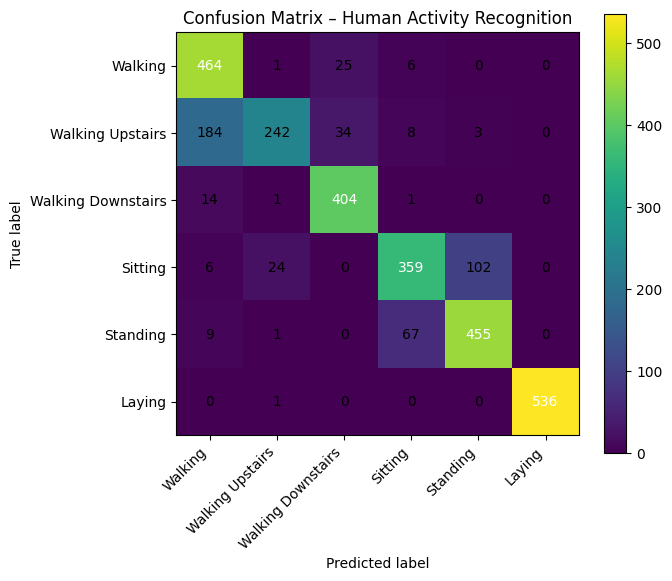

In [15]:
import matplotlib.pyplot as plt
 
class_names = [
    "Walking",
    "Walking Upstairs",
    "Walking Downstairs",
    "Sitting",
    "Standing",
    "Laying",
]
 
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm)
 
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)
 
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Human Activity Recognition")
 
# Werte einzeichnen
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")
 
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()